In [130]:
import tensorflow as tf
import numpy as np


#Import data

# Use the default parameters to keras.datasets.imdb.load_data
start_char = 1
oov_char = 2
index_from = 3
# Retrieve the training sequences.
(x_train_imdb, y_train_imdb), (x_test_imdb, y_test_imdb) = tf.keras.datasets.imdb.load_data()
# Retrieve the word index file mapping words to indices
word_index = tf.keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"
# Decode the first sequence in the dataset
decoded_list = []

for j in range(25000):
  decoded_sequence = " ".join(inverted_word_index[i] for i in x_train_imdb[j])
  decoded_list.append(decoded_sequence)

decoded_list_test = []
for j in range(25000):
  decoded_sequence = " ".join(inverted_word_index[i] for i in x_test_imdb[j])
  decoded_list_test.append(decoded_sequence)


In [131]:
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
import re
def word_extraction(sentence):
  words = re.sub("[^\w]", " ",  sentence).split()
  cleaned_text = [w.lower() for w in words if w not in stopwords]
  return cleaned_text

In [133]:
def tokenize(sentences):
  words = []
  for sentence in sentences:
    w = word_extraction(sentence)
    words.extend(w)
    words = sorted(list(set(words)))
    return words


In [134]:
def generate_bow(allsentences):
  vocab = tokenize(allsentences)
  print("Word List for Document \n{0} \n".format(vocab));


In [135]:
#Create vocabulary
from operator import itemgetter

vocab = dict()
for review in decoded_list:
    words = word_extraction(review)
    for word in words:
      #for i,w in enumerate(vocab):
      if word in vocab:
          vocab[word] += 1
      else:
          vocab[word] = 1
#truncate to 10000 most common words as per paper
sortedVocab = dict(sorted(vocab.items(), key=itemgetter(1), reverse=True)[:10000])
vocab = sortedVocab


In [136]:
#Create bag vectors for each entry
def create_bag_vector(decoded_list, vocab):
  bag_vector = []
  for review in decoded_list:
    bv = np.zeros(len(vocab))
    words = word_extraction(review)
    for word in words:
      if word in vocab:
        index = list(vocab).index(word)
        bv[index] += 1
    bag_vector.append(bv)

  return bag_vector

In [137]:
from tensorflow.python.ops.critical_section_ops import control_flow_ops
#Create Models
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
clf_lr = LogisticRegression()

bv_train = create_bag_vector(decoded_list, vocab)
bv_test = create_bag_vector(decoded_list_test, vocab)



In [138]:
lr = LogisticRegression(penalty='l2', max_iter = 500, C=1, random_state=42)
lr_imdb=lr.fit(bv_train, y_train_imdb)
lr_imdb_predict=lr.predict(bv_test)

In [139]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

lr_imdb_score=accuracy_score(y_test_imdb,lr_imdb_predict)
print("lr_imdb_score :",lr_imdb_score)

lr_imdb_score : 0.8558


In [140]:
lr_bow_report=classification_report(y_test_imdb,lr_imdb_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

              precision    recall  f1-score   support

    Positive       0.85      0.87      0.86     12500
    Negative       0.86      0.84      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [141]:
#IMDB MLP Model - Adam Optimizer

!pip install -q keras
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
#from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.datasets import imdb


model = Sequential()
RANDOM_SEED = 3939
model.add(Dense(32,
                input_shape=(len(vocab),),
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED),
                use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.8))

model.add(Dense(12,
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED),
                use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(1,
                activation="sigmoid",
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))

model.compile(loss="binary_crossentropy", optimizer=Adam(0.0007),
              metrics=["accuracy"])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 32)                320000    
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_36 (Dense)            (None, 12)                384       
                                                                 
 batch_normalization_1 (Bat  (None, 12)                48        
 chNormalization)                                    

In [142]:
arr_train = np.array(bv_train)
arr_test = np.array(bv_test)

In [143]:
history = model.fit(arr_train, y_train_imdb,
                    batch_size=16,
                    epochs=16,
                    verbose=2,
                    validation_data=(arr_test, y_test_imdb))

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1563/1563 - 114s - loss: 0.6002 - accuracy: 0.6699 - val_loss: 0.4229 - val_accuracy: 0.8685 - 114s/epoch - 73ms/step
Epoch 2/16
1563/1563 - 110s - loss: 0.4696 - accuracy: 0.7854 - val_loss: 0.3404 - val_accuracy: 0.8827 - 110s/epoch - 71ms/step
Epoch 3/16
1563/1563 - 108s - loss: 0.4235 - accuracy: 0.8159 - val_loss: 0.3203 - val_accuracy: 0.8855 - 108s/epoch - 69ms/step
Epoch 4/16
1563/1563 - 109s - loss: 0.3942 - accuracy: 0.8348 - val_loss: 0.3099 - val_accuracy: 0.8810 - 109s/epoch - 70ms/step
Epoch 5/16
1563/1563 - 112s - loss: 0.3800 - accuracy: 0.8424 - val_loss: 0.2944 - val_accuracy: 0.8862 - 112s/epoch - 72ms/step
Epoch 6/16
1563/1563 - 112s - loss: 0.3644 - accuracy: 0.8532 - val_loss: 0.2918 - val_accuracy: 0.8841 - 112s/epoch - 72ms/step
Epoch 7/16
1563/1563 - 113s - loss: 0.3608 - accuracy: 0.8516 - val_loss: 0.2985 - val_accuracy: 0.8802 - 113s/epoch - 72ms/step
Epoch 8/16
1563/1563 - 108s - loss: 0.3443 - accuracy: 0.8610 - val_loss: 0.2925 - val_accuracy: 0.8809 - 10

In [144]:

train_score = model.evaluate(arr_train, y_train_imdb, verbose=0)
test_score = model.evaluate(arr_test, y_test_imdb, verbose=0)

train_score, train_accuracy = train_score
print("Train data results:")
print(" - error: {}".format(train_score))
print(" - acc: {}".format(train_accuracy))

test_score, test_accuracy = test_score
print("Test data results:")
print(" - error: {}".format(test_score))
print(" - acc: {}".format(test_accuracy))

Train data results:
 - error: 0.13277556002140045
 - acc: 0.9677600264549255
Test data results:
 - error: 0.30098670721054077
 - acc: 0.8776800036430359


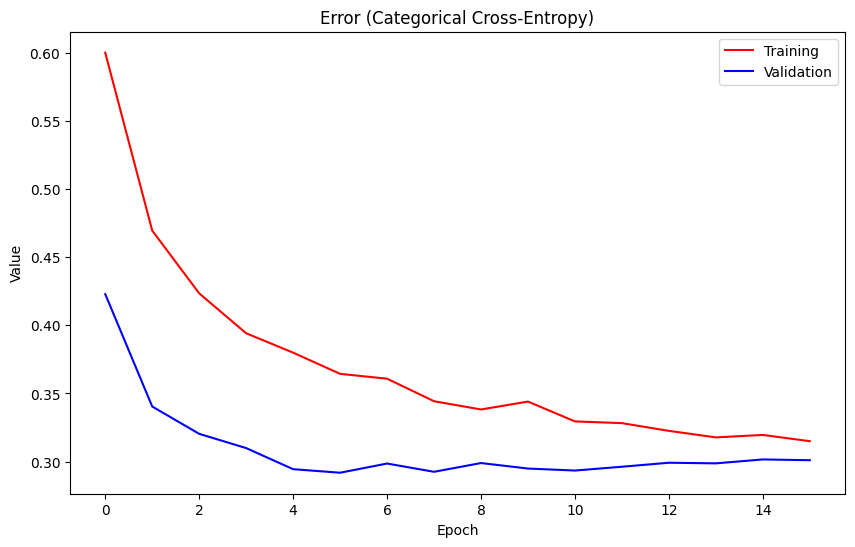

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots()
f.set_size_inches(10, 6)

ax.plot(history.history["loss"], c="r")
ax.plot(history.history["val_loss"], c="b")
ax.set_title("Error (Categorical Cross-Entropy)")
ax.set_ylabel("Value")
ax.set_xlabel("Epoch")
ax.legend(["Training", "Validation"], loc="best");

In [146]:
#MLP - SGD optimizer
from tensorflow.keras.optimizers.legacy import SGD

model = Sequential()
RANDOM_SEED = 3939
model.add(Dense(32,
                input_shape=(len(vocab),),
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED),
                use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.8))

model.add(Dense(12,
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED),
                use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(1,
                activation="sigmoid",
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))

model.compile(loss="binary_crossentropy", optimizer='sgd',
              metrics=["accuracy"])

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 32)                320000    
                                                                 
 batch_normalization_2 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 32)                0         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_39 (Dense)            (None, 12)                384       
                                                                 
 batch_normalization_3 (Bat  (None, 12)                48        
 chNormalization)                                    

In [147]:
arr_train = np.array(bv_train)
arr_test = np.array(bv_test)

In [148]:
history = model.fit(arr_train, y_train_imdb,
                    batch_size=16,
                    epochs=16,
                    verbose=2,
                    validation_data=(arr_test, y_test_imdb))

Epoch 1/16
1563/1563 - 101s - loss: 0.6588 - accuracy: 0.6018 - val_loss: 0.5626 - val_accuracy: 0.8052 - 101s/epoch - 64ms/step
Epoch 2/16
1563/1563 - 101s - loss: 0.5830 - accuracy: 0.6843 - val_loss: 0.4832 - val_accuracy: 0.8359 - 101s/epoch - 65ms/step
Epoch 3/16
1563/1563 - 94s - loss: 0.5373 - accuracy: 0.7282 - val_loss: 0.4360 - val_accuracy: 0.8486 - 94s/epoch - 60ms/step
Epoch 4/16
1563/1563 - 92s - loss: 0.5025 - accuracy: 0.7563 - val_loss: 0.3930 - val_accuracy: 0.8610 - 92s/epoch - 59ms/step
Epoch 5/16
1563/1563 - 91s - loss: 0.4848 - accuracy: 0.7697 - val_loss: 0.3774 - val_accuracy: 0.8662 - 91s/epoch - 58ms/step
Epoch 6/16
1563/1563 - 91s - loss: 0.4622 - accuracy: 0.7860 - val_loss: 0.3507 - val_accuracy: 0.8695 - 91s/epoch - 58ms/step
Epoch 7/16
1563/1563 - 108s - loss: 0.4466 - accuracy: 0.8003 - val_loss: 0.3552 - val_accuracy: 0.8678 - 108s/epoch - 69ms/step
Epoch 8/16
1563/1563 - 94s - loss: 0.4406 - accuracy: 0.8047 - val_loss: 0.3389 - val_accuracy: 0.8732 - 

In [149]:
train_score = model.evaluate(arr_train, y_train_imdb, verbose=0)
test_score = model.evaluate(arr_test, y_test_imdb, verbose=0)

train_score, train_accuracy = train_score
print("Train data results:")
print(" - error: {}".format(train_score))
print(" - acc: {}".format(train_accuracy))

test_score, test_accuracy = test_score
print("Test data results:")
print(" - error: {}".format(test_score))
print(" - acc: {}".format(test_accuracy))

Train data results:
 - error: 0.21998576819896698
 - acc: 0.9275199770927429
Test data results:
 - error: 0.2991553246974945
 - acc: 0.8787999749183655


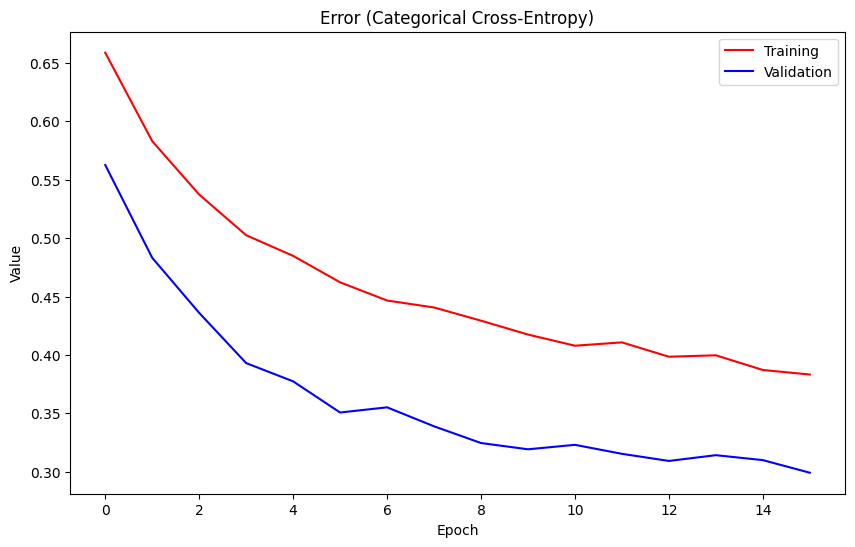

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots()
f.set_size_inches(10, 6)

ax.plot(history.history["loss"], c="r")
ax.plot(history.history["val_loss"], c="b")
ax.set_title("Error (Categorical Cross-Entropy)")
ax.set_ylabel("Value")
ax.set_xlabel("Epoch")
ax.legend(["Training", "Validation"], loc="best");

In [151]:
#CNN - Adam Optimizer

import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,Flatten,Activation,Conv1D,MaxPooling1D, Embedding
from keras.preprocessing import sequence

#fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
max_words = 10000

In [152]:
#create the model
model = Sequential()
model.add(Embedding(10000,32,input_length=max_words))
model.add(Conv1D(32,3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [153]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [154]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 10000, 32)         320000    
                                                                 
 conv1d_8 (Conv1D)           (None, 10000, 32)         3104      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 5000, 32)          0         
 g1D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 160000)            0         
                                                                 
 dense_41 (Dense)            (None, 250)               40000250  
                                                                 
 dense_42 (Dense)            (None, 1)                 251       
                                                     

In [155]:
model.fit(arr_train, y_train_imdb, validation_data=(arr_test,y_test_imdb), epochs=2, batch_size=128, verbose=1)

Epoch 1/2
196/196 [==============================] - 305s 2s/step - loss: 0.4289 - accuracy: 0.8045 - val_loss: 0.3497 - val_accuracy: 0.8548
Epoch 2/2
196/196 [==============================] - 271s 1s/step - loss: 0.2231 - accuracy: 0.9120 - val_loss: 0.3430 - val_accuracy: 0.8603


In [156]:
scores = model.evaluate(arr_test, y_test_imdb, verbose=0)

In [157]:
print("Accuracy: %.2f%%" %(scores[1]*100))

Accuracy: 86.03%


In [158]:
#CNN + SGD Optimizer - IMDB
model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 10000, 32)         320000    
                                                                 
 conv1d_8 (Conv1D)           (None, 10000, 32)         3104      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 5000, 32)          0         
 g1D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 160000)            0         
                                                                 
 dense_41 (Dense)            (None, 250)               40000250  
                                                                 
 dense_42 (Dense)            (None, 1)                 251       
                                                     

In [159]:
model.fit(arr_train, y_train_imdb, validation_data=(arr_test,y_test_imdb), epochs=2, batch_size=128, verbose=1)

Epoch 1/2
196/196 [==============================] - 233s 1s/step - loss: 0.1171 - accuracy: 0.9606 - val_loss: 0.4033 - val_accuracy: 0.8601
Epoch 2/2
196/196 [==============================] - 241s 1s/step - loss: 0.1117 - accuracy: 0.9608 - val_loss: 0.4034 - val_accuracy: 0.8604


In [160]:
scores = model.evaluate(arr_test, y_test_imdb, verbose=0)

In [161]:
print("Accuracy: %.2f%%" %(scores[1]*100))

Accuracy: 86.04%


In [162]:
##########CFAR10#########

#Logistic Regression Model


In [165]:
from keras.datasets import cifar10
from keras.utils import to_categorical

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [166]:
print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


In [167]:
X_train = np.reshape(X_train,(50000,3072))
X_test = np.reshape(X_test,(10000,3072))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 3072)
(50000, 1)
Shape of test data:
(10000, 3072)
(10000, 1)


In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict

lr = LogisticRegression(penalty='l2', max_iter = 500, C=1, random_state=42)
lr_ci=lr.fit(X_train, y_train)
lr_ci_predict=lr.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [169]:
lr_ci_score=accuracy_score(y_test,lr_ci_predict)
print("lr_ci_score :",lr_ci_score)

lr_ci_score : 0.4021


In [170]:
ci_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
lr_ci_report=classification_report(y_test,lr_ci_predict, target_names = ci_classes)
print(lr_ci_report)

              precision    recall  f1-score   support

    airplane       0.45      0.49      0.47      1000
  automobile       0.47      0.46      0.46      1000
        bird       0.32      0.28      0.30      1000
         cat       0.28      0.26      0.27      1000
        deer       0.35      0.30      0.32      1000
         dog       0.32      0.33      0.32      1000
        frog       0.41      0.47      0.44      1000
       horse       0.46      0.44      0.45      1000
        ship       0.50      0.53      0.52      1000
       truck       0.43      0.46      0.45      1000

    accuracy                           0.40     10000
   macro avg       0.40      0.40      0.40     10000
weighted avg       0.40      0.40      0.40     10000



In [171]:
#MLP Model - Adam Optimizer

# Transform label indices to one-hot encoded vectors

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [172]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers.legacy import Adam

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=3072))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [173]:
history = model.fit(X_train,y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1250/1250 [==============================] - 79s 63ms/step - loss: 1.8837 - accuracy: 0.3140 - val_loss: 1.7438 - val_accuracy: 0.3789
Epoch 2/10
1250/1250 [==============================] - 79s 63ms/step - loss: 1.6870 - accuracy: 0.3945 - val_loss: 1.6939 - val_accuracy: 0.3894
Epoch 3/10
1250/1250 [==============================] - 80s 64ms/step - loss: 1.6136 - accuracy: 0.4205 - val_loss: 1.6240 - val_accuracy: 0.4174
Epoch 4/10
1250/1250 [==============================] - 65s 52ms/step - loss: 1.5643 - accuracy: 0.4405 - val_loss: 1.6109 - val_accuracy: 0.4287
Epoch 5/10
1250/1250 [==============================] - 65s 52ms/step - loss: 1.5254 - accuracy: 0.4532 - val_loss: 1.5433 - val_accuracy: 0.4552
Epoch 6/10
1250/1250 [==============================] - 65s 52ms/step - loss: 1.5021 - accuracy: 0.4582 - val_loss: 1.5754 - val_accuracy: 0.4479
Epoch 7/10
1250/1250 [==============================] - 65s 52ms/step - loss: 1.4803 - accuracy: 0.4688 - val_loss: 1.5279 - val_accura

In [174]:
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)

In [175]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[1.4930224418640137, 0.47290000319480896]


In [182]:
#MLP Model - SGD Optimizer

# Transform label indices to one-hot encoded vectors
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = np.reshape(X_train,(50000,3072))
X_test = np.reshape(X_test,(10000,3072))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)



print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 3072)
(50000, 10)
Shape of test data:
(10000, 3072)
(10000, 10)


In [183]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers.legacy import SGD

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=3072))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [184]:
history = model.fit(X_train,y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 41s 33ms/step - loss: 1.8303 - accuracy: 0.3372 - val_loss: 1.7462 - val_accuracy: 0.3698
Epoch 2/10
1250/1250 [==============================] - 40s 32ms/step - loss: 1.6615 - accuracy: 0.4062 - val_loss: 1.6560 - val_accuracy: 0.4007
Epoch 3/10
1250/1250 [==============================] - 39s 31ms/step - loss: 1.5896 - accuracy: 0.4297 - val_loss: 1.6446 - val_accuracy: 0.4169
Epoch 4/10
1250/1250 [==============================] - 41s 33ms/step - loss: 1.5488 - accuracy: 0.4448 - val_loss: 1.5817 - val_accuracy: 0.4365
Epoch 5/10
1250/1250 [==============================] - 39s 32ms/step - loss: 1.5073 - accuracy: 0.4603 - val_loss: 1.5626 - val_accuracy: 0.4511
Epoch 6/10
1250/1250 [==============================] - 38s 31ms/step - loss: 1.4867 - accuracy: 0.4685 - val_loss: 1.5304 - val_accuracy: 0.4564
Epoch 7/10
1250/1250 [==============================] - 37s 30ms/step - loss: 1.4662 - accuracy: 0.4748 - val_loss: 1.5718 -

In [185]:
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)

In [186]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[1.501010775566101, 0.47780001163482666]


In [187]:
#CNN Model - Adam Optimizer
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Flatten,Activation,Conv1D,MaxPooling1D, Embedding
from keras.preprocessing import sequence

#fix random seed for reproducibility
seed = 7
np.random.seed(seed)
max_input = 3072

In [188]:
#create the model
model = Sequential()
model.add(Embedding(3072,32,input_length=max_input))
model.add(Conv1D(32,3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250,activation='relu'))
model.add(Dense(10,activation='sigmoid'))

In [189]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [190]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 3072, 32)          98304     
                                                                 
 conv1d_9 (Conv1D)           (None, 3072, 32)          3104      
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 1536, 32)          0         
 g1D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 49152)             0         
                                                                 
 dense_55 (Dense)            (None, 250)               12288250  
                                                                 
 dense_56 (Dense)            (None, 10)                2510      
                                                     

In [191]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=2, batch_size=128, verbose=1)

Epoch 1/2
391/391 [==============================] - 143s 365ms/step - loss: 0.3240 - accuracy: 0.1304 - val_loss: 0.3191 - val_accuracy: 0.1550
Epoch 2/2
391/391 [==============================] - 138s 353ms/step - loss: 0.3147 - accuracy: 0.1665 - val_loss: 0.3175 - val_accuracy: 0.1639


In [192]:
scores = model.evaluate(X_test, y_test, verbose=0)

In [193]:
print("Accuracy: %.2f%%" %(scores[1]*100))

Accuracy: 16.39%


In [194]:
#CNN Model -  SGD Optimizer
model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 3072, 32)          98304     
                                                                 
 conv1d_9 (Conv1D)           (None, 3072, 32)          3104      
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 1536, 32)          0         
 g1D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 49152)             0         
                                                                 
 dense_55 (Dense)            (None, 250)               12288250  
                                                                 
 dense_56 (Dense)            (None, 10)                2510      
                                                     

In [195]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=2, batch_size=128, verbose=1)

Epoch 1/2
391/391 [==============================] - 123s 316ms/step - loss: 0.3156 - accuracy: 0.1840 - val_loss: 0.3206 - val_accuracy: 0.1389
Epoch 2/2
391/391 [==============================] - 118s 301ms/step - loss: 0.3069 - accuracy: 0.1915 - val_loss: 0.3207 - val_accuracy: 0.1388


In [196]:
scores = model.evaluate(X_test, y_test, verbose=0)

In [197]:
print("Accuracy: %.2f%%" %(scores[1]*100))

Accuracy: 13.88%


In [198]:
##########MNIST#########

#Logistic Regression Model

import tensorflow as tf
import numpy as np

(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()
assert x_train_mnist.shape == (60000, 28, 28)
assert x_test_mnist.shape == (10000, 28, 28)
assert y_train_mnist.shape == (60000,)
assert y_test_mnist.shape == (10000,)

In [199]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [200]:

x_train_mnist = np.reshape(x_train_mnist,(60000,784))
x_test_mnist = np.reshape(x_test_mnist,(10000,784))

train_images = x_train_mnist / 255.0

test_images = x_test_mnist / 255.0


In [201]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict

lr = LogisticRegression(penalty='l2', max_iter = 500, C=1, random_state=42)
lr_mnist=lr.fit(train_images, y_train_mnist)
lr_mnist_predict=lr.predict(test_images)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [202]:
lr_mnist_score=accuracy_score(y_test_mnist,lr_mnist_predict)
print("lr_mnist_score :",lr_mnist_score)

lr_mnist_score : 0.9255


In [203]:
lr_mnist_report=classification_report(y_test_mnist,lr_mnist_predict)
print(lr_mnist_report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



In [204]:
#MLP Model - Adam Optimizer

fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [205]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [206]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
   1/1875 [..............................] - ETA: 2:19 - loss: 2.3511 - accuracy: 0.2188

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1875/1875 [==============================] - 57s 30ms/step - loss: 0.4912 - accuracy: 0.8276
Epoch 2/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.3693 - accuracy: 0.8660
Epoch 3/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.3286 - accuracy: 0.8800
Epoch 4/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.3096 - accuracy: 0.8852
Epoch 5/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.2895 - accuracy: 0.8931
Epoch 6/10
1875/1875 [==============================] - 57s 31ms/step - loss: 0.2750 - accuracy: 0.8976
Epoch 7/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2654 - accuracy: 0.9014
Epoch 8/10
1875/1875 [==============================] - 55s 30ms/step - loss: 0.2533 - accuracy: 0.9063
Epoch 9/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2435 - accuracy: 0.9094
Epoch 10/10
1875/1875 [==============================] - 55s 30ms/step - lo

In [207]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 4s - loss: 0.3414 - accuracy: 0.8811 - 4s/epoch - 11ms/step

Test accuracy: 0.8810999989509583


In [208]:
#MLP Model - SGD Optimizer
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [209]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1948 - accuracy: 0.9289
Epoch 2/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1876 - accuracy: 0.9313
Epoch 3/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1845 - accuracy: 0.9327
Epoch 4/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.1828 - accuracy: 0.9335
Epoch 5/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.1812 - accuracy: 0.9341
Epoch 6/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.1803 - accuracy: 0.9339
Epoch 7/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.1789 - accuracy: 0.9340
Epoch 8/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.1779 - accuracy: 0.9352
Epoch 9/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.1768 - accuracy: 0.9353
Epoch 10/10
1875/1875 [==============================] - 43s 23m

In [210]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 4s - loss: 0.3127 - accuracy: 0.8954 - 4s/epoch - 12ms/step

Test accuracy: 0.8953999876976013


In [211]:
#CNN Model - Adam Optimizer
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Flatten,Activation,Conv1D,MaxPooling1D, Embedding
from keras.preprocessing import sequence

#fix random seed for reproducibility
seed = 7
np.random.seed(seed)
max_input = 784

In [212]:
#create the model
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = np.reshape(train_images,(60000,784))
test_images = np.reshape(test_images,(10000,784))
train_images = train_images / 255.0
test_images = test_images / 255.0


model = Sequential()
model.add(Embedding(784,32,input_length=max_input))
model.add(Conv1D(32,3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250,activation='relu'))
model.add(Dense(10,activation='sigmoid'))

In [213]:
test_labels.shape

(10000,)

In [214]:
new_train_labels = np.eye(10)[train_labels]
new_test_labels = np.eye(10)[test_labels]

In [215]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [216]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 784, 32)           25088     
                                                                 
 conv1d_10 (Conv1D)          (None, 784, 32)           3104      
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 392, 32)           0         
 ng1D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 12544)             0         
                                                                 
 dense_59 (Dense)            (None, 250)               3136250   
                                                                 
 dense_60 (Dense)            (None, 10)                2510      
                                                     

In [217]:
tf.config.run_functions_eagerly(True)
model.fit(train_images, new_train_labels, validation_data=(test_images,new_test_labels), epochs=2, batch_size=128, verbose=1)

Epoch 1/2
469/469 [==============================] - 53s 114ms/step - loss: 0.2560 - accuracy: 0.3936 - val_loss: 0.2335 - val_accuracy: 0.4439
Epoch 2/2
469/469 [==============================] - 53s 113ms/step - loss: 0.2263 - accuracy: 0.4608 - val_loss: 0.2277 - val_accuracy: 0.4556


In [218]:
scores = model.evaluate(test_images, new_test_labels, verbose=0)

In [219]:
print("Accuracy: %.2f%%" %(scores[1]*100))

Accuracy: 45.56%


In [220]:
#CNN Model - SGD Optimizer

model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 784, 32)           25088     
                                                                 
 conv1d_10 (Conv1D)          (None, 784, 32)           3104      
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 392, 32)           0         
 ng1D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 12544)             0         
                                                                 
 dense_59 (Dense)            (None, 250)               3136250   
                                                                 
 dense_60 (Dense)            (None, 10)                2510      
                                                     

In [221]:
tf.config.run_functions_eagerly(True)
model.fit(train_images, new_train_labels, validation_data=(test_images,new_test_labels), epochs=2, batch_size=128, verbose=1)

Epoch 1/2
469/469 [==============================] - 44s 95ms/step - loss: 0.2162 - accuracy: 0.4850 - val_loss: 0.2271 - val_accuracy: 0.4603
Epoch 2/2
469/469 [==============================] - 45s 95ms/step - loss: 0.2156 - accuracy: 0.4870 - val_loss: 0.2269 - val_accuracy: 0.4595


In [222]:
scores = model.evaluate(test_images, new_test_labels, verbose=0)
print("Accuracy: %.2f%%" %(scores[1]*100))

Accuracy: 45.95%


In [224]:
#######RESULT COMPARISON###########
"""As mentioned in the paper, both the Adam and SGD optimizers performed relatively similarly in each of the models created,
 and each resulted in a similar level of accuracy. When looking at performance per epoch, Adam optimization tended to converge
 slightly faster than SGD optimization, which can be attributed to Adam being able to take advantage of sparse features and
 optain faster convergence better than SGD. The models generated here confirm the statements made in the paper.

 Since Adam is less sensitive to hyperparameter tuning, it was able to train the models in a quicker and more suscinct manner,
 whereas the SGD is more vulnerable to "noise" and hyperparameter tuning, especially in sparse datasets. However to be clear,
 the results were not drastically different and both models performed relatively similarly."""


'As mentioned in the paper, both the Adam and SGD optimizers performed relatively similarly in each of the models created,\n and each resulted in a similar level of accuracy. When looking at performance per epoch, Adam optimization tended to converge \n slightly faster than SGD optimization, which can be attributed to Adam being able to take advantage of sparse features and\n optain faster convergence better than SGD. The models generated here confirm the statements made in the paper.\n\n Since Adam is less sensitive to hyperparameter tuning, it was able to train the models in a quicker and more suscinct manner, \n whereas the SGD is more vulnerable to "noise" and hyperparameter tuning, especially in sparse datasets. However to be clear,\n the results were not drastically different and both models performed relatively similarly.'